# 1. Showing the pretrained model knows nothing about MLRun

In [37]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

In [44]:
model_name = "gpt2-medium"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [45]:
prompt = "What is MLRun?"


In [48]:
print(generator(prompt, max_length=150, pad_token_id=tokenizer.eos_token_id)[0]["generated_text"])

What is MLRun? MLRun is a complete web-based application built for interactive analysis and training of machine learning systems. MLRun allows trained training tasks to be used as a learning source in the context of data visualization or data scientific development. MLRun also enables you to generate model files with visualisations, and provides access to training files using a graphical user interface. Furthermore, MLRun is used by numerous data science and AI research labs.

Requirements You'll need:

A computer running Visual Studio 2014-2017 (2013, 2017, 2016), and Python 3 to install Python 3 in a Windows machine.

A web browser to view the document, use the mouse or keyboard to browse the visualisation sources. To find a


# Training pipeline

In [1]:
import mlrun
from src.project_setup import create_and_set_project

project = create_and_set_project(
    git_source="git://github.com/yonishelach/learn-docs.git#main",
    name="mlopspedia-newer",
    default_image="yonishelach/mlrun-hf",
    user_project=True,
)

> 2023-05-17 08:57:17,332 [info] loaded project mlopspedia-newer from MLRun DB


___
<a id="full-workflow"></a>
## Run full LLM life-cycle workflow

Run the training pipeline (in [training_workflow.py](./src/training_workflow.py)) by using `project.run(workflow name, ...)`:
                                                          
* `collect_html_to_text_files` (Data Collection) - Collect all text from given html urls into `.txt` files.
* `prepare_dataset` (Preprocess Data) - Join the `.txt` files, reformatting the text into our "Subject - Content" prompt template. We made every header (`<h>` tags) a *subject* of a prompt, and the text (`<p>` tags) under it as its *content*.
* `train` - Fine-tune the LLM on the data. We'll run the training on **OpenMPI** and we will use **DeepSpeed** for distributing the model and data between multiple workers, splitting the work between nodes and GPUs.
* `evaluate` - Evaluate our model using the *Perplexity* metric.

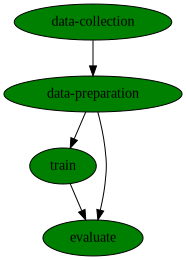

uid,start,state,name,parameters,results
...f81ac8c5,May 17 07:06:33,completed,evaluate,model_path=store://artifacts/mlopspedia-newer-yonis/gpt2-medium-mlrun:e2b71dcf-4287-4bd2-96b2-db1604ca60c7,perplexity=5.092374324798584
...cd7cf47b,May 17 06:52:56,completed,train,model_name=gpt2-medium-mlrunpretrained_tokenizer=gpt2-mediumpretrained_model=gpt2-mediummodel_class=transformers.GPT2LMHeadModeltokenizer_class=transformers.GPT2TokenizerTRAIN_num_train_epochs=15TRAIN_fp16=TrueTRAIN_bf16=FalseTRAIN_per_device_train_batch_size=4TRAIN_logging_strategy=epochuse_deepspeed=True,loss=1.6697learning_rate=5e-05train_runtime=463.2184train_samples_per_second=18.62train_steps_per_second=0.291total_flos=8471017684992.0
...38dffac8,May 17 06:34:09,completed,data-preparation,,
...ae36ed13,May 17 06:33:29,completed,data-collection,urls=https://www.iguazio.com/blog/,


In [2]:
workflow_run = project.run(
    name="training_workflow",
    arguments={
        "html_links": 'https://www.iguazio.com/blog/',
        "model_name": "gpt2-medium-mlrun",
        "pretrained_tokenizer": "gpt2-medium",
        "pretrained_model": "gpt2-medium",
        "model_class": "transformers.GPT2LMHeadModel",
        "tokenizer_class": "transformers.GPT2Tokenizer",
        "epochs": 15,
        "use_deepspeed": True,
    },
    watch=True,
    dirty=True
)

In [9]:
# model_url = project.get_artifact_uri("gpt2-medium-mlrun")

In [2]:
model_url = 'store://artifacts/mlopspedia-newer-yonis/gpt2-medium-mlrun'

# 3. Deploying and serving pipeline with GRadio

In [3]:
serving_function = project.get_function("serving")

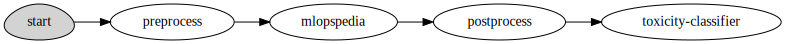

In [4]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

graph.to(handler="preprocess", name="preprocess") \
    .to("LLMModelServer",
        name="mlopspedia",
        model_path=project.get_artifact_uri("gpt2-medium-mlrun"),
        model_class="GPT2LMHeadModel",
        tokenizer_name="gpt2",
        tokenizer_class="GPT2Tokenizer",
        use_deepspeed=False) \
    .to(handler="postprocess", name="postprocess") \
    .to("ToxicityClassifierModelServer",
        name="toxicity-classifier",
        threshold=0.7).respond()

# Plot to graph:
serving_function.plot(rankdir='LR')

In [5]:
serving_function.with_limits(gpus=1)
serving_function.spec.readiness_timeout = 3000
project.set_function(serving_function, with_repo=True)
project.save()

In [ ]:
# Deploy the serving function:
deployment = mlrun.deploy_function("serving")

> 2023-05-17 07:15:30,865 [info] Starting remote function deploy
2023-05-17 07:15:31  (info) Deploying function
2023-05-17 07:15:31  (info) Building
2023-05-17 07:15:31  (info) Staging files and preparing base images
2023-05-17 07:15:31  (info) Building processor image
2023-05-17 07:31:32  (info) Build complete


In [29]:
import gradio as gr
import requests


serving_url = deployment.outputs["endpoint"]

def generate(text, temprature, max_length, top_p, top_k, repetition_penalty):
    inputs = {
        "text": text,
        "temprature": temprature,
        "max_length": max_length,
        "top_p": top_p,
        "top_k": top_k,
        "repetition_penalty": repetition_penalty,
    }
    # call the serving function with the input text
    resp = requests.post(serving_url, data=inputs)
    return resp.json()["outputs"]
    
    
with gr.Blocks() as demo:
    gr.Markdown(
         """
         # MLOps Chat 🚀
         Ask a question about MLOps and set the inference parametes below.
         """
    )
    text = gr.Textbox(label="MLOps Subject to ask about:", placeholder="Please insert text", value="What is machine learning?")
    with gr.Row():
        with gr.Column(scale=1):
            temprature = gr.Slider(0, 1, value=0.9, label="Temperature", info="Choose betwen 0 and 1")
            max_length = gr.Slider(0, 1500, value=150, label="Maximum length", info="Choose betwen 0 and 1500")
            top_p = gr.Slider(0, 1, value=0.9, label="Top P", info="Choose betwen 0 and 1")
            top_k = gr.Slider(0, 500, value=50, label="Top k", info="Choose betwen 0 and 500")
            repetition_penalty = gr.Slider(0, 1, value=1, label="repetition penalty", info="Choose betwen 0 and 1")
        with gr.Column(scale=4):
            output = [gr.Textbox(label="Generated Answer")]
    btn = gr.Button("Submit")
    btn.click(fn=generate, inputs=[text, temprature, max_length, top_p, top_k, repetition_penalty], outputs=output)      

Cannot load darkdefault. Caught Exception: The space darkdefault does not exist


In [26]:
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7867
Running on public URL: https://9bcbe711d890a3ed7c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
